In [33]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
from lime import lime_tabular
from sklearn.utils import shuffle
from datetime import datetime
from pandas import Timestamp


In [34]:
df_data = pd.read_pickle('CleanedDataWithoutChange.pkl') 
df = shuffle(df_data)

In [35]:
'''
Recognize whether a column is numerical or categorical.
:parameter
    :param dtf: dataframe - input data
    :param col: str - name of the column to analyze
    :param max_cat: num - max number of unique values to recognize a column as categorical
:return
    "cat" if the column is categorical or "num" otherwise
'''
def utils_recognize_type(df_replaced_session_einfach, col, max_cat=20):
    if (df[col].dtype == "TestEinfach") | (df[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

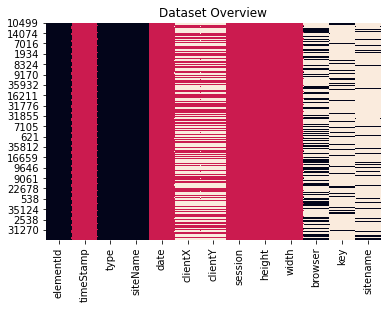

 Categerocial   Numeric   NaN 


In [36]:
dic_cols = {col:utils_recognize_type(df, col, max_cat=20) for col in df.columns}
heatmap = df.isnull()
for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

In [37]:
df = df.set_index("session")
df = df.rename(columns={"siteName":"Y"})
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [38]:
y = "Y"

In [39]:
df['timeStamp'] = df['timeStamp'].astype(float)
df['clientX'] = df['clientX'].astype(float)
df['clientY'] = df['clientX'].astype(float)
df['height'] = df['height'].astype(float)

df['real_date'] = df['date'].astype('datetime64[ns]')
df['real_date'] = (df['real_date'] - df['real_date'].min())  / np.timedelta64(1,'D')


In [40]:
x = "timeStamp"

In [41]:
cat, num = "Y", "timeStamp"

In [42]:
cat, num = "Y", "timeStamp"
model = smf.ols(num+' ~ '+cat, data=df).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Correlated (p-value: 0.0)


In [43]:
cat, num = "Y", "clientY"
model = smf.ols(num+' ~ '+cat, data=df).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Correlated (p-value: 0.0)


In [44]:
cat, num = "Y", "height"
model = smf.ols(num+' ~ '+cat, data=df).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Correlated (p-value: 0.0)


In [45]:
#kann man also je nach Person predicten, oder was für eine Zahl das ist? Eigentlich ja nicht 
cat, num = "Y", 'session'
model = smf.ols(num+' ~ '+cat, data=df).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

PatsyError: Error evaluating factor: NameError: name 'session' is not defined
    session ~ Y
    ^^^^^^^

In [ ]:
cat, num = "Y", 'real_date'
model = smf.ols(num+' ~ '+cat, data=df).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Correlated (p-value: 0.0)


In [ ]:
#Chi-Square test: assuming that two variables are independent (null hypothesis), it tests whether the values of the contingency table for these variables are uniformly distributed.
x, y = "elementId", "Y"
cont_table = pd.crosstab(index=df[x], columns=df[y])
chi2_test = scipy.stats.chi2_contingency(cont_table)
chi2, p = chi2_test[0], chi2_test[1]
n = cont_table.sum().sum()
phi2 = chi2/n
r,k = cont_table.shape
phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
rcorr = r-((r-1)**2)/(n-1)
kcorr = k-((k-1)**2)/(n-1)
coeff = np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))
coeff, p = round(coeff, 3), round(p, 3)
conclusion = "Significant" if p < 0.05 else "Non-Significant"
print("Cramer Correlation:", coeff, conclusion, "(p-value:"+str(p)+")")

Cramer Correlation: 0.717 Significant (p-value:0.0)


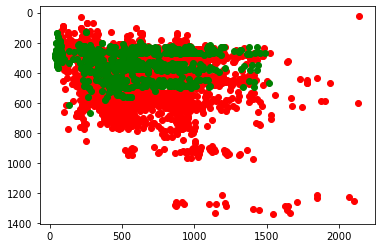

In [ ]:
#clientX und clientY (rot ist schwer, grün ist einfach)

df_mouseover = df.loc[df['type']=='mouseover']
df_mouseout = df.loc[df['type']=='mouseout']
df_mouse = pd.concat([df_mouseover, df_mouseout])

df_seite_schwer = df_mouse.loc[df_mouse['siteName'] == 'TestSchwer']
df_seite_einfach = df_mouse.loc[df_mouse['siteName'] == 'TestEinfach']


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


plt.gca().invert_yaxis()


x_schwer = df_seite_schwer['clientX'].astype(int)
y_schwer = df_seite_schwer['clientY'].astype(int)

x_einfach = df_seite_einfach['clientX'].astype(int)
y_einfach = df_seite_einfach['clientY'].astype(int)

df_schwer = pd.DataFrame(x_schwer, y_schwer)
df_einfach = pd.DataFrame(x_einfach, y_einfach)

plt.scatter(x_schwer,y_schwer, c='red')
plt.scatter(x_einfach,y_einfach,c='green')

In [ ]:
#wuhu split the data 
